
# **Abstracto**
Las tablas de puntaje crediticio son un método común de control de riesgos en la industria financiera a la hora de mitigar el sesgo humano y homogeneizar las respuestas a millones de solicitudes de préstamos. 

Podemos distinguir distintos tipos de scoring (crediticio como en nuestro caso, hipotecario o empresarial), pero en todos ellos, lo que subyace es un estudio de la probabilidad de que una futura operación de un importe determinado acabe entrando en mora. Si esa probabilidad es inferior al limite que designe la entidad financiera, la operación será viable, de lo contrario la solicitud saldría rechazada.

Lógicamente, para hacer esos cálculos, se estudiará la información personal y el comportamiento crediticio del solicitante, es decir, el porcentaje de los ingresos en relación con los pagos comprometidos, la tasa de endeudamiento con respecto al patrimonio, estructura familiar, edad, posición y antigüedad laboral, todo ello será ponderado conforme al algoritmo usado para construir el scoring, y que en función de las políticas crediticias del banco será ajustado cuando proceda.

Con esto en mente, la entidad financiera estaría capacitada para tomar decisiones internas que crea oportunas, conociendo el riesgo que le representaría cada cliente en el futuro y a su vez, la oportunidad de identificar a aquellos usuarios que considere fidelizar.

A continuación, nombramos los principales objetivos a desarrollar de cara a la realización del proyecto


# **Objetivos**

Concretamente, este modelo está enfocado hacia la toma de decisiones internas de la entidad financiera (que sería nuestra audiencia) con el **objetivo** de:
* Identificar a los buenos pagadores (con prestamos vencidos en el periodo de hasta 59 dias) para otorgar facilidades de pago o mejores paquetes como estrategia de fidelizacion.
> Como por ejemplo, aumento de puntaje crediticio, tasas preferenciales en futuros creditos, descuentos exclusivos en tiendas seleccionadas, etc

* Identificar a los malos pagadores (plazos de vencimiento desde 60 dias en adelante) para directamente no otorgarles credito.

* Identificar nuevas acciones a emplear con clientes que no piden credito actualmente para incentivarlos a contratar los servicios del banco.
>Por ejemplo llamar a los clientes ofreciendole tasas preferenciales, primera cuota con un descuento o realizar una acción conjunta en donde se ofrezca una bonificacion (en x meses) para seguros de hogar o su auto.

# **Contexto analítico**
Contamos con 2 tablas pertenecientes a una misma base de datos, que se relacionan por el campo ID.


*  La tabla 'application_record.csv' contiene información personal de los clientes del banco.
*  La tabla 'credit_record.csv', contiene información sobre el status de cada cliente en cada mes.

**Problema comercial:** Crear un modelo de clasificación, para predecir la variable 'status', que refiere al nivel de atraso del cliente en pagar al banco. Dicha variable originalmente tenia los valores que se explican a continuación:
 
  * 0: 1-29 dias de vencimiento.
  * 1: 30-59 dias de vencimiento.
  * 2: 60-89 dias de vencimiento.
  * 3: 90-119 dias de vencimiento.
  * 4: 120-149 dias de vencimiento.
  * 5: Malos creditos, incobrables.
  * C: Pago este mes.
  * X: No pidio prestamo este mes.

Los cuales decidimos agruparlos en las siguientes categorias:

  * 0: No tomadores de prestamo el mes corriente (anteriormente 'X')
  * 1: Buenos pagadores (pertenecientes a las antiguas categorias 'C', '0', y '1')
  * 2: Malos pagadores (pertenecientes a las antiguas categorias '2', '3', '4', y '5')
  
Las variables clave para intentar predecir 'STATUS' serían:
*'AMT_INCOME_TOTAL'(ingreso total), 'NAME_EDUCATION_TYPE' (Nivel de educación), 'OCCUPATION_TYPE' (tipo de ocupación), 'NAME_FAMILY_STATUS' (Estado civil)*, entre otras.

In [ ]:
#!pip install mlxtend

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold #usarlo para encontrar los hiperparámetros, podemos probar con knn, randomforest y SVM
#get_ipython().run_line_magic('load_ext', 'autotime') #Para mostrar el tiempo tardado en correr una celda

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Desafíos Data Science Coderhouse/application_record.csv')
df1.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Desafíos Data Science Coderhouse/credit_record.csv')
df2

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


### Unimos las 2 tablas en un solo dataframe:



In [ ]:
df3 = df2.merge(df1,left_on='ID', right_on='ID')

In [ ]:
df3

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008804,-1,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008804,-2,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
3,5008804,-3,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
4,5008804,-4,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150487,-25,C,M,Y,N,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,-19398,-2166,1,0,0,0,Drivers,2.0
777711,5150487,-26,C,M,Y,N,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,-19398,-2166,1,0,0,0,Drivers,2.0
777712,5150487,-27,C,M,Y,N,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,-19398,-2166,1,0,0,0,Drivers,2.0
777713,5150487,-28,C,M,Y,N,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,-19398,-2166,1,0,0,0,Drivers,2.0


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   MONTHS_BALANCE       777715 non-null  int64  
 2   STATUS               777715 non-null  object 
 3   CODE_GENDER          777715 non-null  object 
 4   FLAG_OWN_CAR         777715 non-null  object 
 5   FLAG_OWN_REALTY      777715 non-null  object 
 6   CNT_CHILDREN         777715 non-null  int64  
 7   AMT_INCOME_TOTAL     777715 non-null  float64
 8   NAME_INCOME_TYPE     777715 non-null  object 
 9   NAME_EDUCATION_TYPE  777715 non-null  object 
 10  NAME_FAMILY_STATUS   777715 non-null  object 
 11  NAME_HOUSING_TYPE    777715 non-null  object 
 12  DAYS_BIRTH           777715 non-null  int64  
 13  DAYS_EMPLOYED        777715 non-null  int64  
 14  FLAG_MOBIL           777715 non-null  int64  
 15  FLAG_WORK_PHONE  

---
Realizamos las siguientes transformaciones en los datos:

* La columna de 'DAYS_BIRTH' por 'AGE' para pasar de datos en dias, a años que es una variable más facil de manejar.
* La columna 'OCCUPATION_TYPE' recibio un relleno en sus valores nulos, por '0'.
* Al igual que la columna 'DAYS_BIRTH', la columna 'DAYS_EMPLOYED' fue reemplazada por 'YEARS_EMPLOYED' para pasar de datos diarios a anuales.
* Teniamos datos negativos en la columna 'YEARS_EMPLOYED', y descubrimos que eran los pertenecientes a la categoria 'PENSIONER' (personas que no cuentan con empleo), por ello reemplazamos estos valores por 0.
* Como se introdujo previamente, realizamos un agrupamiento en la variable 'STATUS'. Esto lo realizamos a fines de simplificar el modelo.
* Se eliminaron las columnas 'DAYS_EMPLOYED' y 'DAYS_BIRTH' ya que sufrieron los cambios mencionados previamente.
* Se convirtieron los datos de la columna *CODE_GENDER* de M y F, a 0 y 1 respectivamente
* Se convirtieron los datos de las columnas *FLAG_OWN_CAR* y *FLAG_OWN_REALTY* de Y, N a 1 y 0 respectivamente
* Se agrego un dato perteneciente a *Malos pagadores* (los valores introducidos fueron la media de cada columna), *Student* con el fin de que exista al menos 1 dato de dicha categoria en *Malos pagadores* y de esta forma los colores de los graficos se respetan.


In [ ]:
df3['AGE']=df3['DAYS_BIRTH']/-365

In [ ]:
df3['OCCUPATION_TYPE'].fillna(0,inplace=True)

In [ ]:
df3['YEARS_EMPLOYED']=df3['DAYS_EMPLOYED']/-365

In [ ]:
df3.drop(columns=['DAYS_EMPLOYED','DAYS_BIRTH'],inplace=True)

In [ ]:
df3[df3['YEARS_EMPLOYED']<-0]['NAME_INCOME_TYPE'].unique()

array(['Pensioner'], dtype=object)

In [ ]:
df3[df3['YEARS_EMPLOYED']<-0]['YEARS_EMPLOYED'].unique()

array([-1000.66575342])

In [ ]:
df3.loc[df3.YEARS_EMPLOYED<0,'YEARS_EMPLOYED']=0

In [ ]:
print(df3[df3['YEARS_EMPLOYED']<0])

Empty DataFrame
Columns: [ID, MONTHS_BALANCE, STATUS, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, AGE, YEARS_EMPLOYED]
Index: []


In [ ]:
df3['STATUS'] = df3['STATUS'].replace(['C', '0','1'],'1')

In [ ]:
df3['STATUS'] = df3['STATUS'].replace(['2', '3', '4', '5'],'2')

In [ ]:
df3['STATUS'] = df3['STATUS'].replace(['X'],'0')

In [ ]:
df3['STATUS'] = df3['STATUS'].astype(int)
print(df3['STATUS'].value_counts())

1    628937
0    145950
2      2828
Name: STATUS, dtype: int64


In [ ]:
df3['CODE_GENDER'] = df3['CODE_GENDER'].replace('M', 1)
df3['CODE_GENDER'] = df3['CODE_GENDER'].replace('F', 0)
df3['CODE_GENDER'] = df3['CODE_GENDER'].astype(int)

In [ ]:
df3['FLAG_OWN_CAR'] = df3['FLAG_OWN_CAR'].replace('Y', 1)
df3['FLAG_OWN_CAR'] = df3['FLAG_OWN_CAR'].replace('N', 0)
df3['FLAG_OWN_CAR'] = df3['FLAG_OWN_CAR'].astype(int)

In [ ]:
df3['FLAG_OWN_REALTY'] = df3['FLAG_OWN_REALTY'].replace('Y', 1)
df3['FLAG_OWN_REALTY'] = df3['FLAG_OWN_REALTY'].replace('N', 0)
df3['FLAG_OWN_REALTY'] = df3['FLAG_OWN_CAR'].astype(int)

# Sample el df

Hicimos una partición del dataframe (con 100000 datos en total), con el fin de reducir los tiempos de procesado, ya que era virtualmente imposible realizar los entrenamientos de modelos y grillas con un dataset tan grande (aproximadamente 2 millones de datos luego del oversampling aplicado debajo con la función smoteTOMEK). Para ser consistentes en todo el trabajo, realizamos el eda con el dataset sampleado, teniendo en cuenta que los porcentajes de participación en cada 'STATUS' prácticamente no han variado luego del sampleo, como se muestra más abajo

In [ ]:
df = df3.copy()
df

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
0,5008804,0,1,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,0,2.0,32.890411,12.443836
1,5008804,-1,1,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,0,2.0,32.890411,12.443836
2,5008804,-2,1,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,0,2.0,32.890411,12.443836
3,5008804,-3,1,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,0,2.0,32.890411,12.443836
4,5008804,-4,1,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,0,2.0,32.890411,12.443836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150487,-25,1,1,1,1,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Drivers,2.0,53.145205,5.934247
777711,5150487,-26,1,1,1,1,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Drivers,2.0,53.145205,5.934247
777712,5150487,-27,1,1,1,1,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Drivers,2.0,53.145205,5.934247
777713,5150487,-28,1,1,1,1,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Drivers,2.0,53.145205,5.934247


In [ ]:
df = df.sample(random_state=42,
               n= 100000)
print(df['STATUS'].value_counts())

print('─' * 30)
print('Porcentajes de cada status en el dataset original:\n')
print('Status 0:', len(df3[df3['STATUS']== 0]) * 100 / len(df3))
print('Status 1:', len(df3[df3['STATUS']== 1]) * 100 / len(df3))
print('Status 2:', len(df3[df3['STATUS']== 2]) * 100 / len(df3))
print('─' * 30)
print('Porcentajes de cada status en el dataset sampleado:\n')
print('Status 0 sample:', len(df[df['STATUS']== 0]) * 100 / len(df))
print('Status 1 sample:', len(df[df['STATUS']== 1]) * 100 / len(df))
print('Status 2 sample:', len(df[df['STATUS']== 2]) * 100 / len(df))

1    81039
0    18608
2      353
Name: STATUS, dtype: int64
──────────────────────────────
Porcentajes de cada status en el dataset original:

Status 0: 18.766514725831442
Status 1: 80.8698559240853
Status 2: 0.3636293500832567
──────────────────────────────
Porcentajes de cada status en el dataset sampleado:

Status 0 sample: 18.608
Status 1 sample: 81.039
Status 2 sample: 0.353


# Análisis Exploratorio de los Datos (EDA)

In [ ]:
df.describe()

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.078811e+06,-19.323200,0.817450,0.332850,0.391130,0.391130,0.431820,1.889206e+05,1.0,0.232830,0.299590,0.090530,2.212910,44.118798,6.376006
std,4.170369e+04,14.045219,0.395332,0.471236,0.488006,0.488006,0.747835,1.024059e+05,0.0,0.422637,0.458081,0.286941,0.909707,11.246953,6.699677
min,5.008804e+06,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,21.109589,0.000000
25%,5.044855e+06,-29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.224000e+05,1.0,0.000000,0.000000,0.000000,2.000000,34.769863,1.178082
50%,5.074747e+06,-17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.620000e+05,1.0,0.000000,0.000000,0.000000,2.000000,43.079452,4.624658
75%,5.115519e+06,-8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.250000e+05,1.0,0.000000,1.000000,0.000000,3.000000,53.257534,9.030137
max,5.150487e+06,0.000000,2.000000,1.000000,1.000000,1.000000,14.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,15.000000,68.909589,43.049315


Al realizar un análisis descriptivo de nuestras variables, notamos que en el campo 'STATUS', la mayoría de los clientes se encuentran en el estado 1. Al evaluar los cuartiles, podemos ver que el valor 1 es el más frecuente en el primer, segundo y tercer cuartil.

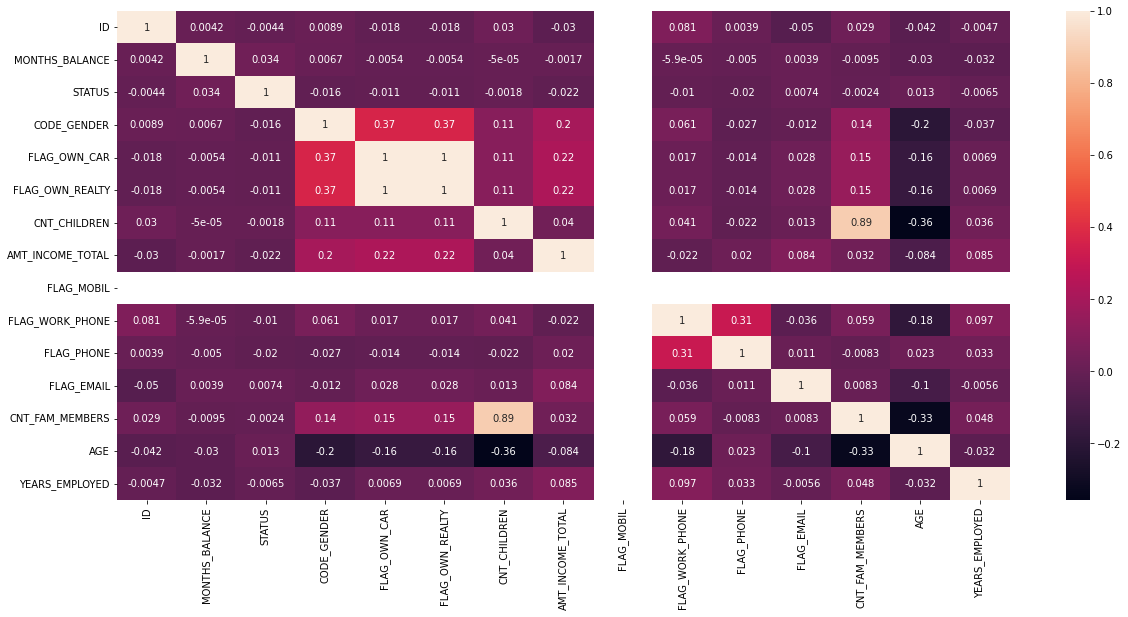

In [ ]:
plt.figure(figsize=(20,9))
sns.heatmap(data=df.corr(), annot=True);

Realizamos un análisis de correlación entre la variable 'STATUS' y las demás para evaluar la relación entre ellas. Al observar la matriz, se puede concluir que las correlaciones entre las variables son suaves, por lo que seguiremos investigando con otros métodos para obtener conclusiones más precisas.

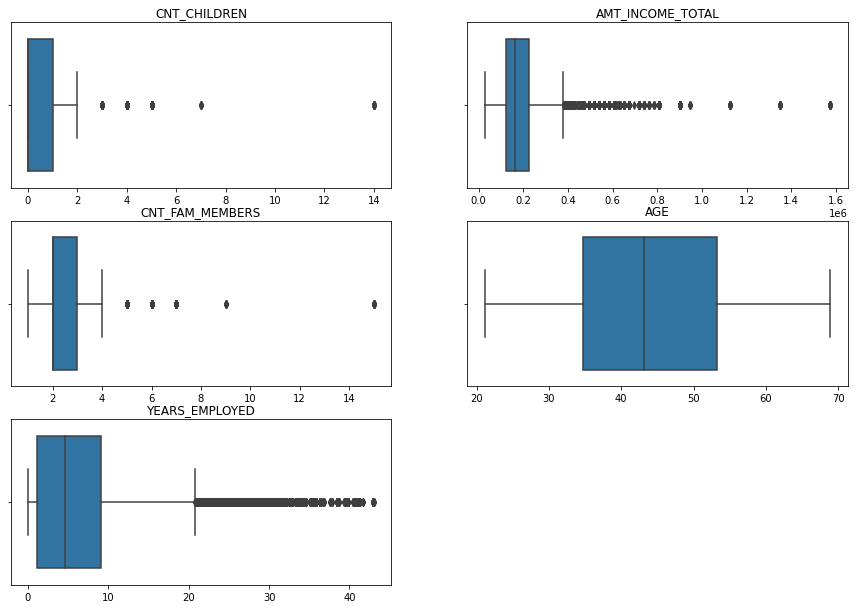

In [ ]:
#Boxplot de las variables numéricas para ver outliers
plt.figure(figsize=(15,14))
for i,j in zip(range(5),df[['CNT_CHILDREN','AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','AGE','YEARS_EMPLOYED']].columns): 
  plt.subplot(4,2, i+1) 
  sns.boxplot(x=df[['CNT_CHILDREN','AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','AGE','YEARS_EMPLOYED']][j]) 
  plt.title(j)
  plt.xlabel('')

Observamos que la variable AGE tiene una distribución simétrica y no tiene outliers (lo cual es lógico, ya que el banco otorga préstamos solo hasta cierta edad).

El resto de las variables presentan una distribución asimétrica derecha con outliers a la derecha.

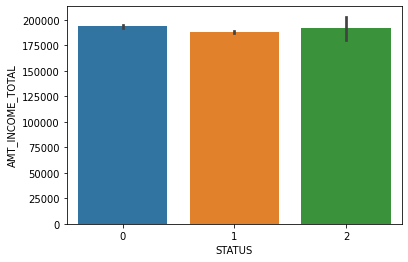

In [ ]:
#bar-plot
ax = sns.barplot(data=df, x='STATUS', y='AMT_INCOME_TOTAL')

Graficamos el salario promedio para cada categoria de status de pago.
Observamos que no hay una relación inversa entre la demora en el pago y el monto de ingresos anuales, lo cual era una hipótesis que teníamos.

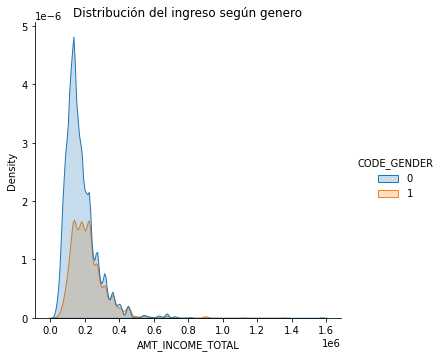

In [ ]:
#Grafico de densidad
ax = sns.displot(data=df, x='AMT_INCOME_TOTAL', kind='kde', hue='CODE_GENDER', fill=True)
ax.set(title = 'Distribución del ingreso según genero');

Graficamos la distribución del ingreso segregando por hombres y mujeres y observamos que la misma es asimétrica derecha, es decir que la mayoría de las personas ganan salarios bajos

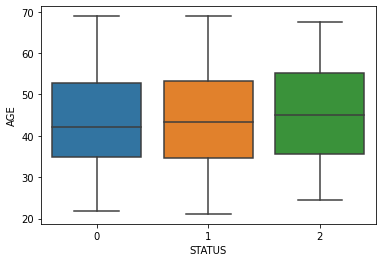

In [ ]:
#Box-plot
sns.boxplot(data=df, x="STATUS", y="AGE");

Graficamos la distribución de probabilidad de la edad para cada categoría de status.
Observamos que la mayoría de las personas en cada grupo de status tienen edades similares (lo cual tiene sentido ya que la mayoría se encuentra entre 30 y 55 años, que se
condice con la edad laboral activa)

In [ ]:
IDS_y_status = df[['ID','STATUS']]
IDS_agrupados = IDS_y_status.groupby(by = 'STATUS').count()
IDS_agrupados

,ID
STATUS,
0,18608
1,81039
2,353


In [ ]:
#Gráfico de torta
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]], 
                    subplot_titles=[F" Cantidad de clientes en cada STATUS <br><sup> Total:{df[['ID','STATUS']].shape[0]}</sup>"])

fig.add_trace(go.Pie(labels=IDS_agrupados.index, values=IDS_agrupados['ID']), row=1, col=1)

fig.update_traces(marker=dict(colors=['#4F6272', '#B7C3F3', '#DD7596', '#8EB897', '#F3FF00']))
fig.show()

Hicimos una torta para ver en que grupo de status se encuentra la mayoría de los usuarios
Observamos que la mayoría son buenos pagadores
También hay una proporción alta que no pidió préstamo y otra que pagó a tiempo

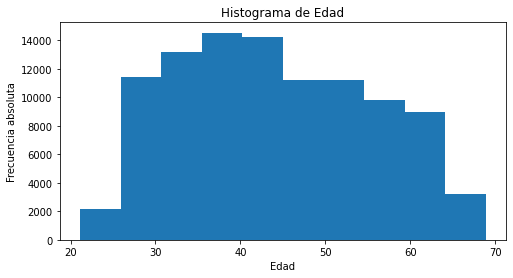

In [ ]:
#Histograma
fig, ax = plt.subplots(figsize = (8, 4))
ax.hist(df['AGE'], bins=10)
ax.set_title('Histograma de Edad')
ax.set_xlabel('Edad')
ax.set_ylabel('Frecuencia absoluta');

Graficamos la distribución de probabilidad de la edad de los clientes del banco cada mes
Observamos una distribución simétrica, ubicándose la mayoria de las personas entre los 30 y 60 años

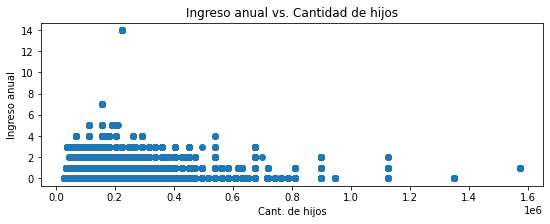

In [ ]:
#Scatterplot
fig, ax = plt.subplots(figsize=(9,3)) 
ax.scatter(df['AMT_INCOME_TOTAL'], df['CNT_CHILDREN'], alpha=1) 
ax.set_title('Ingreso anual vs. Cantidad de hijos')
ax.set_xlabel('Cant. de hijos')
ax.set_ylabel('Ingreso anual');

Realizamos un scatterplot para intentar de ver si hay alguna relación entre el ingreso de las personas y su cantidad de hijos
No se observa una relación clara

---
Vamos a plantearnos algunas hipótesis sobre relaciones entre la variables 'status' (que es nuestra variable a predecir) y otras variables que puedan afectarla.


## **Hipótesis 1:** 
Las personas con un cargo de commercial associate son las que demoran menos en pagar, mientras que los de cargo working/pensioner son los que mas demoran.

Generamos 3 datasets haciendo una agrupacion por tipo de empleo para cada nivel de status.

In [ ]:
Empleos_status0 = df[df['STATUS']==0][['NAME_INCOME_TYPE','ID']].groupby(by='NAME_INCOME_TYPE').count()
Empleos_status1 = df[df['STATUS']==1][['NAME_INCOME_TYPE','ID']].groupby(by='NAME_INCOME_TYPE').count()
Empleos_status2 = df[df['STATUS']==2][['NAME_INCOME_TYPE','ID']].groupby(by='NAME_INCOME_TYPE').count()
Empleos_status1

,ID
NAME_INCOME_TYPE,
Commercial associate,19142
Pensioner,13442
State servant,6834
Student,34
Working,41587


A continuación se realizará un histograma para cada tipo de empleo acerca de la participacion de cada STATUS en el mismo.
<br>
La idea es ver si para algun tipo de empleo, se observa un mayor peso del _STATUS 2_

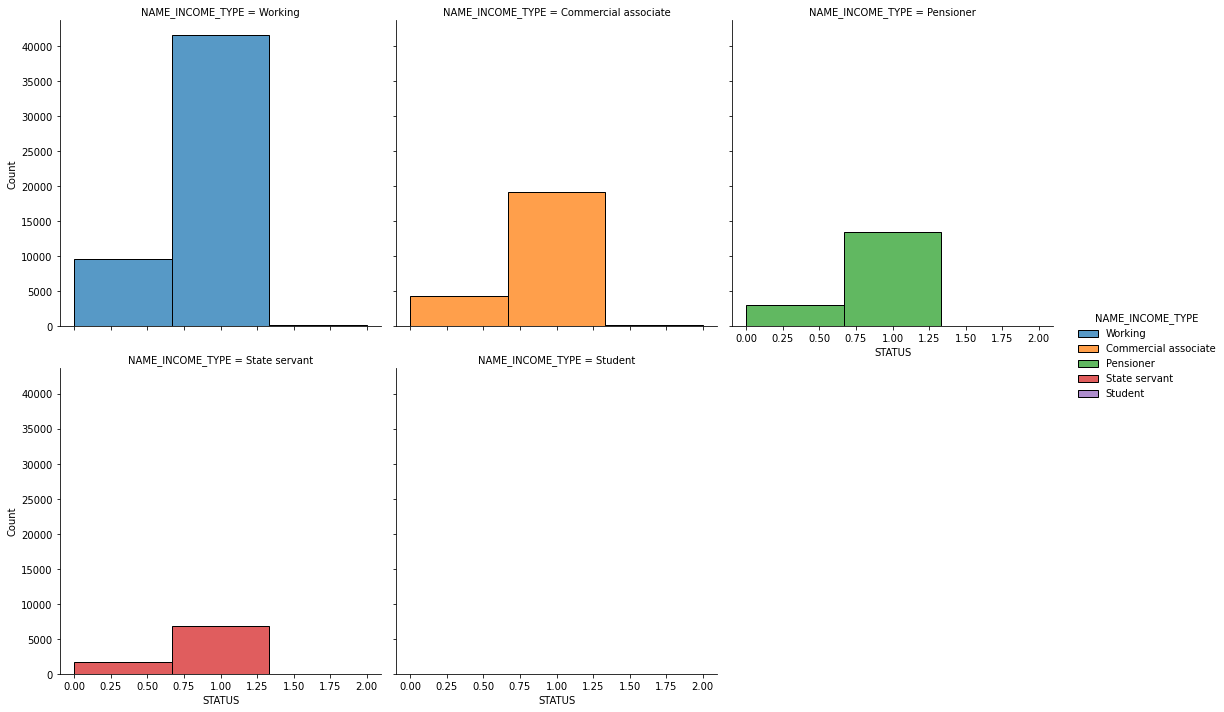

In [ ]:
sns.displot(data=df, x=df["STATUS"].astype(object), hue="NAME_INCOME_TYPE", 
            multiple="stack", col="NAME_INCOME_TYPE", col_wrap=3, bins=3);

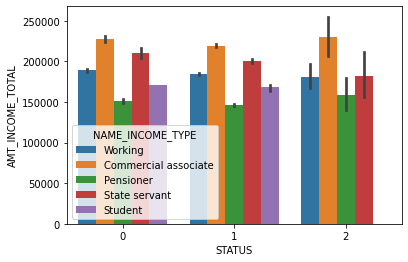

In [ ]:
sns.barplot(data=df, x=df["STATUS"].astype(object), y='AMT_INCOME_TOTAL', hue="NAME_INCOME_TYPE");

A continuacion se realizaran graficos de torta correspondientes a la segmentacion por empleo de la variable _STATUS_.
<br>
Nuestra intencion es mostrar que porcentaje representa cada segmentacion de empleo para cada uno de los _STATUS_.
<br>
Si observamos que aumenta la participación de _Working_ y _Pensioner_ se comprobaría nuestra hipótesis 1.

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=[F" Status 0: No tomó préstamo <br><sup> Total:{df[df['STATUS'] == 0].shape[0]}</sup>", 
                                    F" Status 1: Buenos pagadores <br><sup> Total:{df[df['STATUS'] == 1].shape[0]}</sup>", 
                                    F" Status 2: Malos pagadores <br><sup> Total:{df[df['STATUS'] == 2].shape[0]}</sup>"])

fig.add_trace(go.Pie(labels=Empleos_status0.index, values = Empleos_status0['ID']), row=1, col=1)
fig.add_trace(go.Pie(labels=Empleos_status1.index, values = Empleos_status1['ID']), row=1, col=2)
fig.add_trace(go.Pie(labels=Empleos_status2.index, values = Empleos_status2['ID']), row=1, col=3)
fig.update_traces(marker=dict(colors=['#4F6272', '#B7C3F3', '#DD7596', '#8EB897', '#F3FF00']))
fig.show()

In [ ]:
print('Working:',df.query('NAME_INCOME_TYPE=="Working" & STATUS==2').shape[0] / df.query('NAME_INCOME_TYPE=="Working"').shape[0], '%')
print('Student:',df.query('NAME_INCOME_TYPE=="Student" & STATUS==2').shape[0] / df.query('NAME_INCOME_TYPE=="Student"').shape[0], '%')
print('State servant:',df.query('NAME_INCOME_TYPE=="State servant" & STATUS==2').shape[0] / df.query('NAME_INCOME_TYPE=="State servant"').shape[0], '%')
print('Pensioner:',df.query('NAME_INCOME_TYPE=="Pensioner" & STATUS==2').shape[0] / df.query('NAME_INCOME_TYPE=="Pensioner"').shape[0], '%')
print('Commercial associate:',df.query('NAME_INCOME_TYPE=="Commercial associate" & STATUS==2').shape[0] / df.query('NAME_INCOME_TYPE=="Commercial associate"').shape[0], '%')

Working: 0.0027660361922200363 %
Student: 0.0 %
State servant: 0.002119891649982334 %
Pensioner: 0.004781214065242389 %
Commercial associate: 0.004828053532102321 %


## Insights obtenidos:

* A medida que la categoria de status va creciendo se observa que los **commercial associate** van aumentando su participación dentro de la categoría de status. Es decir, que a medida que hay mayor demora en los pagos, mayor es la participación de los commercial associate (Aunque el aumento no es muy grande).

* Mientras que observamos que los **state servants** y **working**, van disminuyendo su participación al aumentar la categoría de status


* **Pensioner** : observamos que los pensioner tienen una mayor ponderación en las categoría 2.

**Conclusión:** rechazamos nuestra hipótesis inicial. Se observa que hay una mayor cantidad de commercial associate en la categoria malos pagadores.
Podemos observar tambien que, las personas pensionadas y los commercial associates representan una mayoria proporcional de malos pagadores; esta inferencia no esta relacionada con el ingreso como podemos observar, ya que los commercial associate son los que mayor ingreso tienen y aun asi, representan una proporcion mayoritaria entre los malos pagadores.

---
## **Hipótesis 2:**
Las personas con menor grado de educación alcanzado son aquellas que mas demoran en pagar.

In [ ]:
print(df['NAME_EDUCATION_TYPE'].unique())

['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


Generamos 3 datasets haciendo una agrupacion por nivel de educacion para cada nivel de status.

In [ ]:
Educación_status0 = df[df['STATUS']==0][['NAME_EDUCATION_TYPE','ID']].groupby(by='NAME_EDUCATION_TYPE').count()
Educación_status1 = df[df['STATUS']==1][['NAME_EDUCATION_TYPE','ID']].groupby(by='NAME_EDUCATION_TYPE').count()
Educación_status2 = df[df['STATUS']==2][['NAME_EDUCATION_TYPE','ID']].groupby(by='NAME_EDUCATION_TYPE').count()
Educación_status0

,ID
NAME_EDUCATION_TYPE,
Academic degree,13
Higher education,5484
Incomplete higher,668
Lower secondary,184
Secondary / secondary special,12259


Vamos a realizar gráficos de torta con la intencion de mostrar que porcentaje representa cada nivel educacional para cada uno de los 'STATUS'.

Si observamos que en el paso de status 1 a 2 crecen en porcentaje las categorias _secondary / secondary special_ y _lower secondary_, se cumpliria nuestra hipótesis

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=[F" Status 0: No tomó préstamo <br><sup> Total:{df[df['STATUS'] == 0].shape[0]}</sup>", 
                                    F" Status 1: Buenos pagadores <br><sup> Total:{df[df['STATUS'] == 1].shape[0]}</sup>", 
                                    F" Status 2: Malos pagadores <br><sup> Total:{df[df['STATUS'] == 2].shape[0]}</sup>"])

fig.add_trace(go.Pie(labels=Educación_status0.index, values = Educación_status0['ID']), row=1, col=1)              
fig.add_trace(go.Pie(labels=Educación_status1.index, values = Educación_status1['ID']), row=1, col=2)
fig.add_trace(go.Pie(labels=Educación_status2.index, values = Educación_status2['ID']), row=1, col=3)

fig.update_traces(marker=dict(colors=['#4F6272', '#B7C3F3', '#DD7596', '#8EB897', '#F3FF00']))


fig.show()

A continuación se realizará un histograma para cada nivel de educación acerca de la participacion de cada STATUS en el mismo.

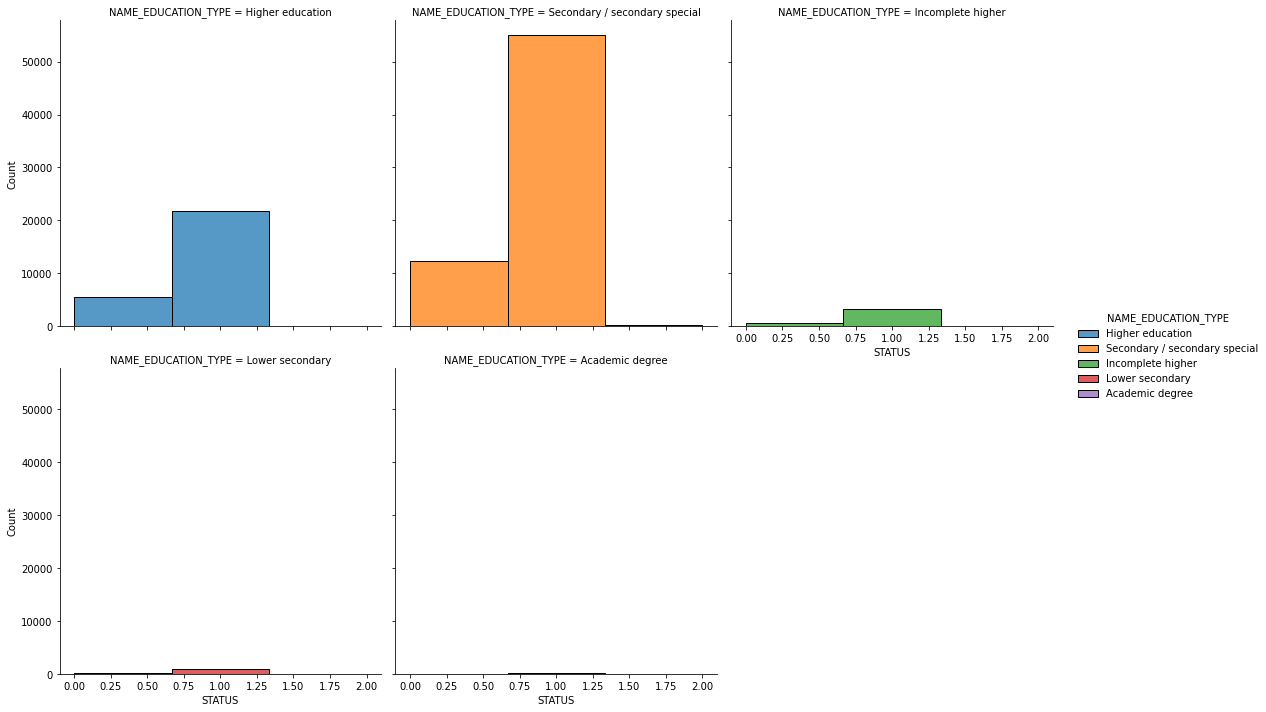

In [ ]:
sns.displot(data=df, x="STATUS", hue="NAME_EDUCATION_TYPE", multiple="stack", col="NAME_EDUCATION_TYPE", col_wrap=3, bins=3);

A continuación se calculará el ratio de _Malos pagadores_ para cada nivel de educación.
<br>
Esto nos permite ver con mas claridad lo ya visto en los histogramas.
<br>
En los histogramas se puede visualizar el poco peso que presenta el _STATUS 2_, por lo cual no se aprecia la participación de el en cada clase de educación. Mientras que con los ratios esta participación se puede apreciar mejor.

In [ ]:
print('Higher education:',df.query('NAME_EDUCATION_TYPE=="Higher education" & STATUS==2').shape[0] * 100 / df.query('NAME_EDUCATION_TYPE=="Higher education"').shape[0], '%')
print('Secondary / secondary special:',df.query('NAME_EDUCATION_TYPE=="Secondary / secondary special" & STATUS==2').shape[0] * 100 / df.query('NAME_EDUCATION_TYPE=="Secondary / secondary special"').shape[0], '%')
print('Incomplete higher:',df.query('NAME_EDUCATION_TYPE=="Incomplete higher" & STATUS==2').shape[0] * 100 / df.query('NAME_EDUCATION_TYPE=="Incomplete higher"').shape[0], '%')
print('Lower secondary:',df.query('NAME_EDUCATION_TYPE=="Lower secondary" & STATUS==2').shape[0] * 100 / df.query('NAME_EDUCATION_TYPE=="Lower secondary"').shape[0], '%')
print('Academic degree:',df.query('NAME_EDUCATION_TYPE=="Academic degree" & STATUS==2').shape[0] * 100 / df.query('NAME_EDUCATION_TYPE=="Academic degree"').shape[0], '%')

Higher education: 0.4817869917512227 %
Secondary / secondary special: 0.2904220009483167 %
Incomplete higher: 0.3552397868561279 %
Lower secondary: 1.0185185185185186 %
Academic degree: 0.0 %


## Insights obtenidos:

1. Observamos que para cada nivel de status, la distribución de las personas en función de su nivel educativo, es muy similar en todos los niveles. 
2. Se puede observar un incremento porcentual en categoria 'Higher education', y un decremento en la categoria 'Secondary / Secondary special'
3. Además, observamos que porcentualmente, la categoria con mayor cantidad de malos pagadores es 'Lower secondary', aunque con resultados no contundentes
4. En resúmen, si bien se observa un aumento porcentual de _lower secondary_ dentro de _Malos pagadores_, su participacion es pequeña. En contraposición se observa un aumento significativo de _Higher education_ dentro de _Malos pagadores_. 

**Conclusión:** Rechazamos la hipótesis 2

## **Hipótesis 3**:
Queremos demostrar que aquellas personas solas (viudos, separados, solteros), tienen una mejor conducta crediticia.

In [ ]:
df['NAME_FAMILY_STATUS'].unique()

array(['Married', 'Single / not married', 'Widow', 'Separated',
       'Civil marriage'], dtype=object)

Generamos 3 datasets haciendo una agrupacion por estado civil para cada nivel de status.

In [ ]:
Estadocivil_status0=df[df['STATUS']==0][['NAME_FAMILY_STATUS','ID']].groupby(by='NAME_FAMILY_STATUS').count()
Estadocivil_status1=df[df['STATUS']==1][['NAME_FAMILY_STATUS','ID']].groupby(by='NAME_FAMILY_STATUS').count()
Estadocivil_status2=df[df['STATUS']==2][['NAME_FAMILY_STATUS','ID']].groupby(by='NAME_FAMILY_STATUS').count()


A continuación se realizará un histograma para cada estado civil acerca de la participacion de cada STATUS en el mismo.
<br>
La idea es ver si para algun estado civil, se observa un mayor peso del STATUS 2.
<br>
Si vemos que dentro de _Widow_ y/o _Separated_ y/o _Single / not married_, el peso de _STATUS 2_ es proporcionalmente menor a la de los demás estados civiles, se comprobaria nuestra hipótesis 3.

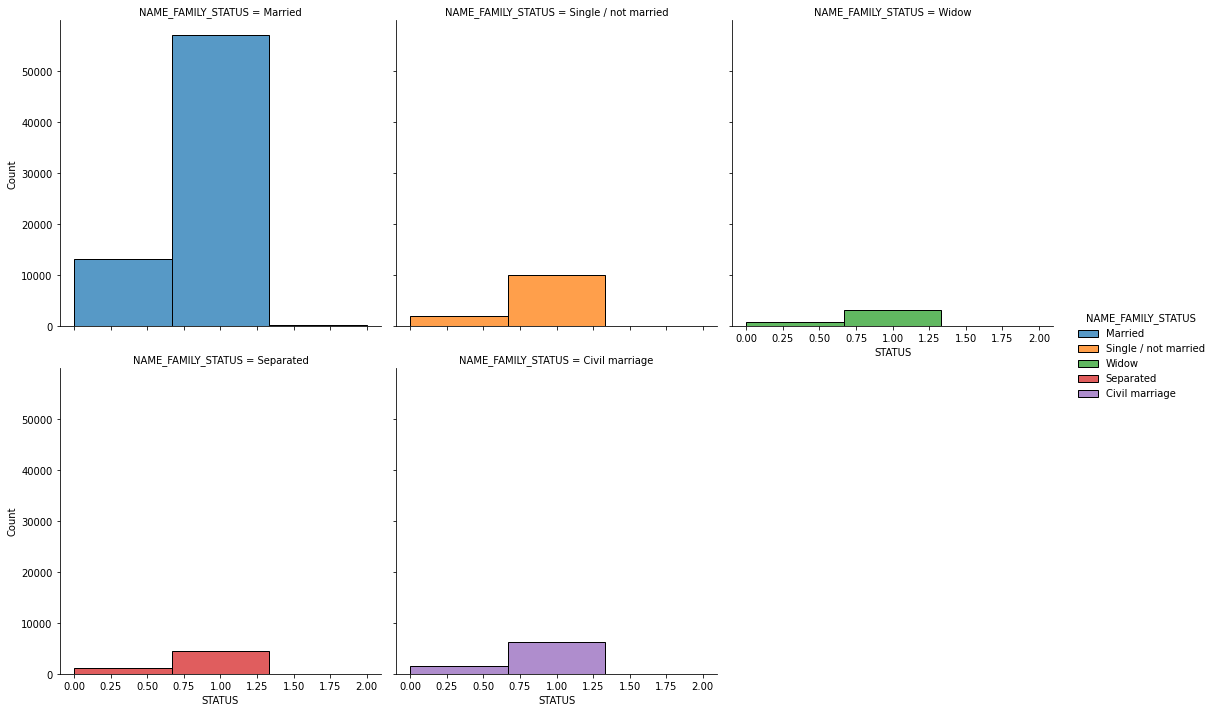

In [ ]:
sns.displot(data=df, x="STATUS", hue="NAME_FAMILY_STATUS", multiple="stack", col="NAME_FAMILY_STATUS", col_wrap=3, bins=3);

Vamos a realizar gráficos de torta con la intencion de mostrar que porcentaje representa cada estado civil para cada uno de los 'STATUS'.
<br>
Si observamos que en el paso de status 1 a 2 crecen en porcentaje las categorias Widow y/o Separated y/o Single / not married, se cumpliria nuestra hipótesis

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=[F" Status 0: No tomó préstamo <br><sup> Total:{df[df['STATUS'] == 0].shape[0]}</sup>", 
                                    F" Status 1: Buenos pagadores <br><sup> Total:{df[df['STATUS'] == 1].shape[0]}</sup>", 
                                    F" Status 2: Malos pagadores <br><sup> Total:{df[df['STATUS'] == 2].shape[0]}</sup>"])

fig.add_trace(go.Pie(labels=Estadocivil_status0.index, values = Estadocivil_status0['ID']), row=1, col=1)              
fig.add_trace(go.Pie(labels=Estadocivil_status1.index, values = Estadocivil_status1['ID']), row=1, col=2)
fig.add_trace(go.Pie(labels=Estadocivil_status2.index, values = Estadocivil_status2['ID']), row=1, col=3)

fig.update_traces(marker=dict(colors=['#4F6272', '#B7C3F3', '#DD7596', '#8EB897', '#F3FF00']))

fig.show()

In [ ]:
print('Married:',df.query('NAME_FAMILY_STATUS=="Married" & STATUS==2').shape[0] * 100 / df.query('NAME_FAMILY_STATUS=="Married"').shape[0], '%')
print('Civil marriage:',df.query('NAME_FAMILY_STATUS=="Civil marriage" & STATUS==2').shape[0] * 100  / df.query('NAME_FAMILY_STATUS=="Civil marriage"').shape[0], '%')
print('Widow:',df.query('NAME_FAMILY_STATUS=="Widow" & STATUS==2').shape[0] * 100  / df.query('NAME_FAMILY_STATUS=="Widow"').shape[0], '%')
print('Single:',df.query('NAME_FAMILY_STATUS=="Single / not married" & STATUS==2').shape[0] * 100  / df.query('NAME_FAMILY_STATUS=="Single / not married"').shape[0], '%')
print('Separated:',df.query('NAME_FAMILY_STATUS=="Separated" & STATUS==2').shape[0] * 100  / df.query('NAME_FAMILY_STATUS=="Separated"').shape[0], '%')

Married: 0.3422080227192048 %
Civil marriage: 0.15645371577574968 %
Widow: 0.4570848146267141 %
Single: 0.46435845213849286 %
Separated: 0.4392129304286718 %


## Insights obtenidos:
Observamos practicamente la misma distribución según estado civil dentro de cada categoría de status. Pero, **rechazamos nuestra hipótesis**, ya que se observa que en la categoría malos pagadores, hay un mayor porcentaje de personas no casadas (separados, solteros, viudos).
También observamos que el estado civil en el cual hay un mayor porcentaje de malos pagadores es 'Widow' (pero el porcentaje es muy bajo: 0,48%)

## **Hipótesis 4**
Aquellos clientes del banco con menos años de experiencia laboral, son los más morosos.

In [ ]:
#categorizamos la variable 'YEARS_EMPLOYED' para poder graficarla mejor
bins=[0,5,10,15,25,44]
labels=['0-5 años exp','5-10 años exp','10-15 años exp','15-25 años exp','25-44 años exp']
cats=pd.cut(df['YEARS_EMPLOYED'], bins, labels=labels)
df['EXP_RANGOS']=cats
df

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED,EXP_RANGOS
489996,5096070,-27,1,0,1,1,0,180000.0,Working,Higher education,...,House / apartment,1,1,0,1,Core staff,2.0,40.939726,4.520548,0-5 años exp
293437,5061151,-20,0,1,1,1,3,202500.0,Working,Secondary / secondary special,...,House / apartment,1,0,1,0,0,5.0,36.438356,10.049315,10-15 años exp
544675,5111166,-23,0,1,1,1,0,202500.0,Working,Secondary / secondary special,...,House / apartment,1,0,1,1,Managers,1.0,36.830137,6.904110,5-10 años exp
688170,5137185,-1,1,0,1,1,0,67500.0,Working,Secondary / secondary special,...,House / apartment,1,1,0,0,0,2.0,31.246575,5.298630,5-10 años exp
582519,5115498,0,0,1,1,1,2,225000.0,Commercial associate,Secondary / secondary special,...,House / apartment,1,0,0,0,Laborers,4.0,44.065753,3.786301,0-5 años exp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671902,5135383,-15,1,0,0,0,0,387000.0,Commercial associate,Secondary / secondary special,...,House / apartment,1,0,0,0,Sales staff,2.0,55.019178,13.641096,10-15 años exp
407258,5087865,-5,1,0,1,1,0,112500.0,Pensioner,Secondary / secondary special,...,Rented apartment,1,0,0,0,0,2.0,66.627397,0.000000,NaN
414103,5088990,-29,1,0,0,0,2,171000.0,Working,Secondary / secondary special,...,House / apartment,1,1,1,0,Core staff,4.0,40.060274,3.178082,0-5 años exp
567880,5113868,-41,1,0,0,0,0,90000.0,Working,Secondary / secondary special,...,House / apartment,1,0,0,0,Sales staff,2.0,44.150685,2.698630,0-5 años exp


A continuación se realizará un histograma para cada rango de experiencia acerca de la participacion de cada STATUS en el mismo.
<br>
La idea es ver si para algun rango, presenta un mayor peso del STATUS 2

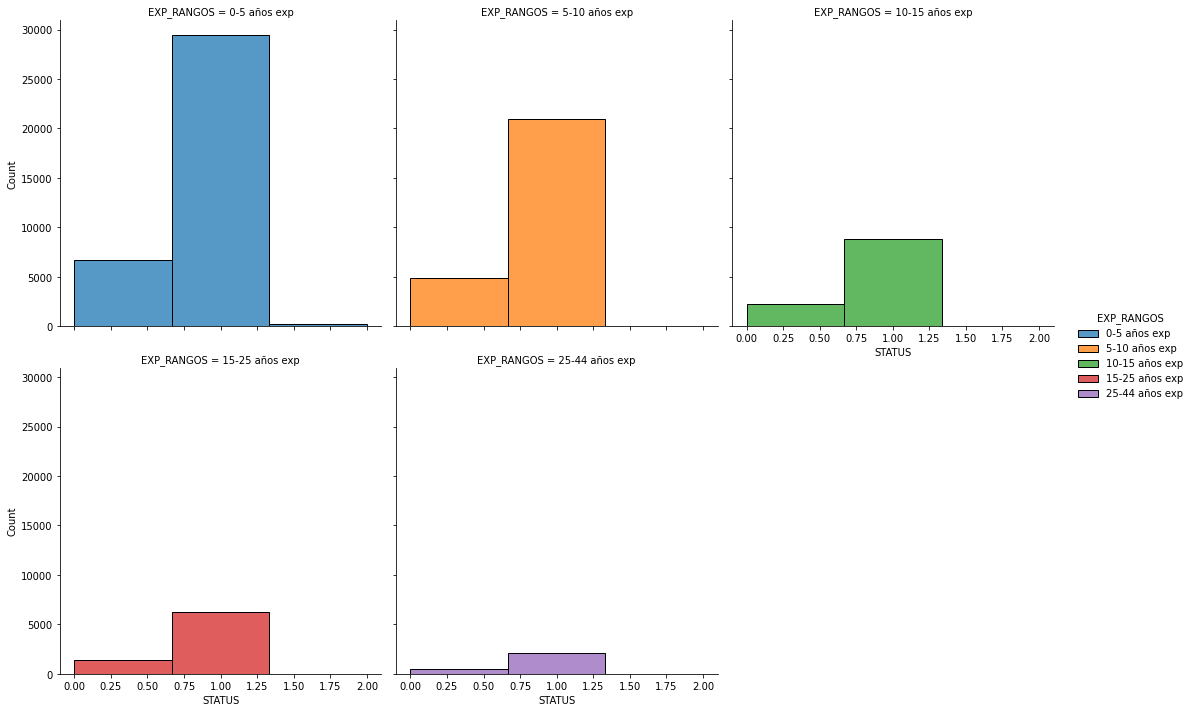

In [ ]:
sns.displot(data=df, x="STATUS", hue="EXP_RANGOS", multiple="stack", col="EXP_RANGOS", col_wrap=3,bins=3);

In [ ]:
print('0-5 años exp:',df.query('EXP_RANGOS=="0-5 años exp" & STATUS==2').shape[0] * 100 / df.query('EXP_RANGOS=="0-5 años exp"').shape[0], '%')
print('5-10 años exp:',df.query('EXP_RANGOS=="5-10 años exp" & STATUS==2').shape[0] * 100  / df.query('EXP_RANGOS=="5-10 años exp"').shape[0], '%')
print('10-15 años exp:',df.query('EXP_RANGOS=="10-15 años exp" & STATUS==2').shape[0] * 100  / df.query('EXP_RANGOS=="10-15 años exp"').shape[0], '%')
print('15-25 años exp:',df.query('EXP_RANGOS=="15-25 años exp" & STATUS==2').shape[0] * 100  / df.query('EXP_RANGOS=="15-25 años exp"').shape[0], '%')
print('25-44 años exp:',df.query('EXP_RANGOS=="25-44 años exp" & STATUS==2').shape[0] * 100  / df.query('EXP_RANGOS=="25-44 años exp"').shape[0], '%')

0-5 años exp: 0.5260693530173245 %
5-10 años exp: 0.1850352723487915 %
10-15 años exp: 0.2788772939906441 %
15-25 años exp: 0.1571503404924044 %
25-44 años exp: 0.1973943939992104 %


## Insights obtenidos:
Se observa que la mayor cantidad de los clientes del banco poseen entre 0 y 5 años de experiencia.

Y con respecto a nuestra hipótesis, podemos aceptarla, pero el efecto es muy leve; ya que se observa que el comportamiento de la morosidad es prácticamente igual para cada rango de años de experiencia. Aunque observamos que hay un porcentaje mayor en el rango 0 a 5 años de experiencia (0.51%)

# Propuestas Comerciales en base a insights obtenidos
* **Propuesta 1**: 
Proponemos ofrecer tasas diferenciales, acorde a las necesidades de la clase trabajadora, de manera que puedan refinanciar sus deudas sin caer en incobrabilidad. 

  Diseñamos esta propuesta, ya que vemos que dentro de los malos pagadores, predominan los trabajadores (42%).
* **Propuesta 2**:
Lograr que aquellos que no tienen prestamos (categoría 0), empiecen a tomarlos. 
¿Cómo? Remarcando los beneficios que trae para el cliente.
Puede ayudarle a tener un buen historial crediticio, de esta manera va a tener la oportunidad de acceder a mejores préstamos y oportunidades a largo plazo. El hecho de tener un buen historial crediticio y llevar un largo tiempo con la institución bancaria le va a permitir tomar un préstamo preaprobado de forma inmediata y por un importe significativo.
Otra posibilidad para incentivar a los clientes a tomar un préstamo, podría ser la posibilidad de premiar con puntos para canjear por distintos premios y beneficios en los Marketplace de las entidades bancarias.

  Diseñamos esta propuesta, ya que observamos que hay una gran número de clientes que se encuentran actualmente sin tomar préstamo.

  Relacionado con esto, observamos que de los clientes que no toman préstamo, aproximadamente el 50% son trabajadores depensientes; por lo tanto sugerimos una acción específica para éstos. Dicha acción, podría ser, llevar adelante convenios con empresas para que los trabajadores cobren su sueldo en una cuenta del banco, con las cuales tengan oportunidades crediticias.

# Elección y entrenamiento del modelo

Nuestra variable target es 'STATUS', la cual es categórica y posee 3 categorías. Por lo cual utilizaremos algoritmos supervisados de clasificación, ya que se conoce a priori el número de clases y los reconocimientos de patrones representantes de cada clase. Los algoritmos a evaluar serán Random Forest y K Nearest Neighbours.
Para cada uno de estos, probaremos un entrenamiento del modelo base, del modelo con los mejores parámetros obtenidos con RandomizedSearchCV, y también emplearemos una validación cruzada con StratifiedKFolds, para obtener las mejores particiones de train y test.

Adicionalmente, observamos que nuestra variable target ('STATUS') posee desbalanceo de clases, por lo cual entrenaremos al modelo con los datos originales, para ver los resultados. En caso de no ser los mismos satisfactorios, emplearemos la técnica de oversampling con 'SMOTETomek'.

## Preprocesamiento de datos

In [ ]:
#Target
y=df['STATUS']
#Features
x=df.drop(columns=['STATUS','EXP_RANGOS'])

time: 0 ns (started: 2023-01-05 22:11:09 -03:00)


In [ ]:
#Utilizamos one hot encoding para x
dummies=pd.get_dummies(x[['CODE_GENDER','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                          'OCCUPATION_TYPE']], prefix=['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                                                       'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE'], drop_first=True)

time: 47 ms (started: 2023-01-05 22:11:09 -03:00)


In [ ]:
dummies

,CODE_GENDER,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
489996,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
293437,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
544675,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
688170,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
582519,1,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671902,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
407258,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
414103,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
567880,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0


time: 16 ms (started: 2023-01-05 22:11:09 -03:00)


In [ ]:
dummies.columns

Index(['CODE_GENDER', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
       'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
       'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR staff',
       'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_IT staff',
     

time: 0 ns (started: 2023-01-05 22:11:09 -03:00)


In [ ]:
x.drop(columns=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE',
                'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE'], inplace=True)
x

,ID,MONTHS_BALANCE,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
489996,5096070,-27,0,180000.0,1,1,0,1,2.0,40.939726,4.520548
293437,5061151,-20,3,202500.0,1,0,1,0,5.0,36.438356,10.049315
544675,5111166,-23,0,202500.0,1,0,1,1,1.0,36.830137,6.904110
688170,5137185,-1,0,67500.0,1,1,0,0,2.0,31.246575,5.298630
582519,5115498,0,2,225000.0,1,0,0,0,4.0,44.065753,3.786301
...,...,...,...,...,...,...,...,...,...,...,...
671902,5135383,-15,0,387000.0,1,0,0,0,2.0,55.019178,13.641096
407258,5087865,-5,0,112500.0,1,0,0,0,2.0,66.627397,0.000000
414103,5088990,-29,2,171000.0,1,1,1,0,4.0,40.060274,3.178082
567880,5113868,-41,0,90000.0,1,0,0,0,2.0,44.150685,2.698630


time: 31 ms (started: 2023-01-05 22:11:09 -03:00)


In [ ]:
x = x.join(dummies)
x

,ID,MONTHS_BALANCE,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
489996,5096070,-27,0,180000.0,1,1,0,1,2.0,40.939726,...,0,0,0,0,0,0,0,0,0,0
293437,5061151,-20,3,202500.0,1,0,1,0,5.0,36.438356,...,0,0,0,0,0,0,0,0,0,0
544675,5111166,-23,0,202500.0,1,0,1,1,1.0,36.830137,...,0,0,1,0,0,0,0,0,0,0
688170,5137185,-1,0,67500.0,1,1,0,0,2.0,31.246575,...,0,0,0,0,0,0,0,0,0,0
582519,5115498,0,2,225000.0,1,0,0,0,4.0,44.065753,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671902,5135383,-15,0,387000.0,1,0,0,0,2.0,55.019178,...,0,0,0,0,0,0,1,0,0,0
407258,5087865,-5,0,112500.0,1,0,0,0,2.0,66.627397,...,0,0,0,0,0,0,0,0,0,0
414103,5088990,-29,2,171000.0,1,1,1,0,4.0,40.060274,...,0,0,0,0,0,0,0,0,0,0
567880,5113868,-41,0,90000.0,1,0,0,0,2.0,44.150685,...,0,0,0,0,0,0,1,0,0,0


time: 47 ms (started: 2023-01-05 22:11:09 -03:00)


In [ ]:
x.columns

Index(['ID', 'MONTHS_BALANCE', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED', 'CODE_GENDER',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
       'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
       'OCCUPATION_TYPE_Coo

time: 0 ns (started: 2023-01-05 22:11:09 -03:00)


In [ ]:
#Eliminamos las columnas 'ID' y 'MONTHS_BALANCE' para que el modelo no aprenda de ellas, ya que no tienen relevancia en el contexto comercial
x.drop(columns=['ID','MONTHS_BALANCE'],inplace=True)

time: 15 ms (started: 2023-01-05 22:11:09 -03:00)


In [ ]:
#Escalando el dataset
scaler=StandardScaler(copy=False)
x=scaler.fit_transform(x)
x1=x.copy()
x

array([[-0.57742978, -0.08711024,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [ 3.43417076,  0.13260482,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [-0.57742978,  0.13260482,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       ...,
       [ 2.09697058, -0.17499627,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [-0.57742978, -0.9659705 ,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [-0.57742978, -0.52654037,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314]])

time: 125 ms (started: 2023-01-05 22:11:09 -03:00)


## Separando dataset en un set de train  y test 

A continuación dividmos la muestra en train (70%) y test (30%)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=2)

time: 78 ms (started: 2023-01-05 22:11:10 -03:00)


In [ ]:
x_train

array([[-0.57742978,  1.23118015,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [-0.57742978,  0.13260482,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [ 2.09697058, -0.52654037,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       ...,
       [-0.57742978, -0.21893928,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [-0.57742978, -0.74625544,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [-0.57742978, -0.9659705 ,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314]])

time: 0 ns (started: 2023-01-05 22:11:10 -03:00)


In [ ]:
x_test

array([[-0.57742978, -0.17499627,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [-0.57742978, -0.30682531,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [-0.57742978,  0.57203495,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       ...,
       [ 2.09697058, -0.57048339,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [ 0.7597704 , -0.30682531,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314],
       [-0.57742978, -0.08711024,  0.        , ..., -0.06337243,
        -0.12715039, -0.05806314]])

time: 0 ns (started: 2023-01-05 22:11:10 -03:00)


In [ ]:
y_train

435833    1
537025    0
460566    1
1194      1
387366    1
         ..
173774    1
175624    0
449434    0
751775    1
724128    0
Name: STATUS, Length: 70000, dtype: int32

time: 0 ns (started: 2023-01-05 22:11:10 -03:00)


In [ ]:
y_test

629038    1
421914    0
580289    1
651051    0
367786    1
         ..
239550    1
328538    1
737529    1
512221    1
431216    1
Name: STATUS, Length: 30000, dtype: int32

time: 15 ms (started: 2023-01-05 22:11:10 -03:00)


In [ ]:
y_train.value_counts()

1    56704
0    13048
2      248
Name: STATUS, dtype: int64

time: 0 ns (started: 2023-01-05 22:11:10 -03:00)


## Entrenamiento, Evaluación y Optimización del modelo

### RandomForestClassifier

Vamos a utilizar un modelo de clasificación como RandomForestClassifier, utilizando sus parámetros por defecto al principio, a excepción del número de estimadores, el cual elegimos 20, ya que su número por defecto es 100, y nosotros decidimos reducir esta cantidad con el afán de mejorar el rendimiento del código.

In [ ]:
rf_prim = RandomForestClassifier(random_state=42, n_estimators=20)
rf_prim.fit(x_train,y_train)
y_predicted_rf_prim = rf_prim.predict(x_test)

time: 1.58 s (started: 2023-01-05 22:11:10 -03:00)


In [ ]:
print(classification_report(y_test,y_predicted_rf_prim))

              precision    recall  f1-score   support

           0       0.64      0.43      0.51      5560
           1       0.88      0.95      0.91     24335
           2       0.57      0.19      0.29       105

    accuracy                           0.85     30000
   macro avg       0.70      0.52      0.57     30000
weighted avg       0.83      0.85      0.83     30000

time: 16 ms (started: 2023-01-05 22:11:11 -03:00)


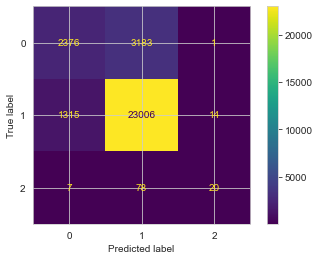

time: 78 ms (started: 2023-01-05 22:11:11 -03:00)


In [ ]:
cm_rf_prim = confusion_matrix(y_test, y_predicted_rf_prim, labels=rf_prim.classes_)
disp_rf_prim = ConfusionMatrixDisplay(confusion_matrix=cm_rf_prim, display_labels=rf_prim.classes_)
disp_rf_prim.plot();

---

### Evaluacion de métricas obtenidas



Las métricas a evaluar son las siguientes:

En cuanto al desempeño general de las métricas, podemos observar que la clase 1 es explicada correctamente por el modelo. En especifico una primera interpretacion de los resultados obtenidos en esta metrica son:

* **Precisión:** Nos indica que la calidad del modelo es buena debido a que, en caso de aparecer "buenos clientes pagadores", los predecirá correctamente en la mayoria de los casos.

* **Recall:** Esta metrica nos da a entender con que facilidad el modelo identifica un cliente. En la clase mencionada (1) es elevada, ya que tenemos un numero elevado de verdaderos positivos. 

* **F1:** Nos indica que tenemos pocos falsos positivos y negativos, lo cual indica que tenemos altas probabilidades que un futuro cliente sea categorizado correctamente. Ademas esta métrica es muy buena para nuestro caso de estudio, ya que se presenta el desbalanceo de clases mencionado en el final.

* **Accuracy:** En general, las predicciones realizadas por el modelo se acercan a los datos reales; de todas maneras tuvimos cuidado con esta metrica ya que un valor muy cercano a 1 puede darnos a entender un caso de overfitting.

En contraposicion, lo que encontramos fue que para el resto de las clases (0 y 2), los valores de las metricas se encontraban por la mitad o cercanas a 0. De esta manera se observa que el modelo no maneja bien estas clases para predecirlas y categorizarlas con facilidad y precisión, lo que reflejaria que el modelo se encuentra en un caso de underfitting (no podría predecir en base al score crediticio si es un mal pagador o un cliente que no tomó deuda este mes).

Para solucionar esto implementaremos la herramienta SMOTE-Tomek


### SMOTE-Tomek

Técnica muy usada que consiste en aplicar en simultáneo un algoritmo de subsampling y otro de oversampling a la vez al dataset. 
En este caso usaremos SMOTE para oversampling para buscar puntos vecinos cercanos y agregar puntos “en linea recta” entre ellos, y usaremos Tomek para undersampling que quita los de distinta clase que sean nearest neighbor y deja ver mejor el decisión boundary (la zona limítrofe de nuestras clases)

In [ ]:
oversample_st = SMOTETomek(random_state=1)
x_train_st, y_train_st = oversample_st.fit_resample(x_train, y_train)
x_test_st, y_test_st = oversample_st.fit_resample(x_test, y_test)

time: 21.7 s (started: 2023-01-05 22:11:11 -03:00)


### Random Forest, post ST

En base a iteraciones entre algoritmos de clasificacion y el posterior analisis de sus métricas, conluimos que el algoritmo mejor ajustado a nuestro proyecto es Random Forest.

In [ ]:
rf_st = RandomForestClassifier(random_state=42, n_estimators=20)
rf_st.fit(x_train_st,y_train_st)
y_predicted_rf_st = rf_st.predict(x_test_st)

time: 4.5 s (started: 2023-01-05 22:11:33 -03:00)


In [ ]:
print(classification_report(y_test_st,y_predicted_rf_st))

              precision    recall  f1-score   support

           0       0.62      0.79      0.70     24268
           1       0.74      0.82      0.78     24272
           2       0.97      0.60      0.74     24329

    accuracy                           0.74     72869
   macro avg       0.78      0.74      0.74     72869
weighted avg       0.78      0.74      0.74     72869

time: 47 ms (started: 2023-01-05 22:11:38 -03:00)


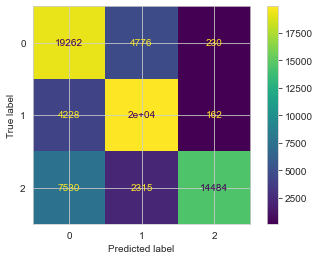

time: 109 ms (started: 2023-01-05 22:11:38 -03:00)


In [ ]:
cm_rf_st = confusion_matrix(y_test_st, y_predicted_rf_st, labels=rf_st.classes_)
disp_rf_st = ConfusionMatrixDisplay(confusion_matrix=cm_rf_st, display_labels=rf_st.classes_)
disp_rf_st.plot();

### StratifiedKFolds

Usamos SKF con 5 particiones de nuestra muestra, para realizar una validación cruzada del modelo, y lograr mejores métricas.

In [ ]:
x_st = np.concatenate((x_train_st, x_test_st), axis=0)
y_st = np.concatenate((y_train_st, y_test_st), axis=0)

time: 15 ms (started: 2023-01-05 22:11:38 -03:00)


In [ ]:
x_st.shape

(242911, 45)

time: 0 ns (started: 2023-01-05 22:11:38 -03:00)


In [ ]:
y_st

array([1, 0, 1, ..., 2, 2, 2])

time: 0 ns (started: 2023-01-05 22:11:38 -03:00)


In [ ]:
y_st.shape

(242911,)

time: 0 ns (started: 2023-01-05 22:11:38 -03:00)


In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=40, shuffle=True)

time: 0 ns (started: 2023-01-05 22:11:38 -03:00)


In [ ]:
# Inicializa la lista para almacenar las puntuaciones F1
f1_scores = []

# Itera sobre cada submuestra
for train_index, test_index in skf.split(x_st, y_st):
    # Separa los datos en train y test utilizando los índices obtenidos por la función split
    x_train, x_test = x_st[train_index], x_st[test_index]
    y_train, y_test = y_st[train_index], y_st[test_index]

    # Entrena el modelo con los datos de entrenamiento
    rf_st.fit(x_train, y_train)

    # Realiza predicciones con el modelo entrenado en los datos de prueba
    y_pred = rf_st.predict(x_test)

    # Calcula la puntuación F1
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average=None)

    # Guarda la puntuación F1 en la lista
    f1_scores.append(f1)

time: 25.2 s (started: 2023-01-05 22:11:38 -03:00)


In [ ]:
f1_scores

[array([0.84648043, 0.84248262, 0.99198969]),
 array([0.84981483, 0.8440867 , 0.99192335]),
 array([0.85060976, 0.84444165, 0.99176803]),
 array([0.84741769, 0.84591341, 0.99186942]),
 array([0.84420012, 0.84138921, 0.99275095])]

time: 0 ns (started: 2023-01-05 22:12:03 -03:00)


>Tomaremos la mejor iteración de skf para entrenar nuevamente al modelo y obtener las mejores métricas posibles.

In [ ]:
# Obtiene los índices para cada split
split_indices = list(skf.split(x_st, y_st))

# Selecciona el tercer split
train_index, test_index = split_indices[2]

time: 31 ms (started: 2023-01-05 22:12:03 -03:00)


In [ ]:
# Separa los datos en train y test utilizando los índices obtenidos por la función split
x_train, x_test = x_st[train_index], x_st[test_index]
y_train, y_test = y_st[train_index], y_st[test_index]

time: 31 ms (started: 2023-01-05 22:12:03 -03:00)


In [ ]:
# Entrena el modelo con los datos de entrenamiento
rf_st.fit(x_train, y_train)

# Realiza predicciones con el modelo entrenado en los datos de prueba
y_pred = rf_st.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     16187
           1       0.86      0.83      0.84     16190
           2       0.99      1.00      0.99     16205

    accuracy                           0.90     48582
   macro avg       0.90      0.90      0.90     48582
weighted avg       0.90      0.90      0.90     48582

time: 4.99 s (started: 2023-01-05 22:12:03 -03:00)


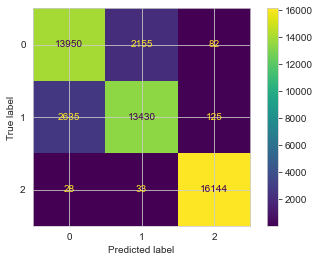

time: 141 ms (started: 2023-01-05 22:12:08 -03:00)


In [ ]:
cm_rf_cv = confusion_matrix(y_test, y_pred, labels=rf_st.classes_)
disp_rf_cv = ConfusionMatrixDisplay(confusion_matrix=cm_rf_cv, display_labels=rf_st.classes_)
disp_rf_cv.plot();

### RandomizedSearchCV-RF


Buscarémos la mejor combinación de parámetros para nuestro modelo.

In [ ]:
rf_grid = RandomForestClassifier(random_state=42)
params = {
    'n_estimators' : [10,100,200], #cantidad de arboles del modelo
    'criterion':['gini', 'entropy', 'log_loss'], #para medir la calidad de las ramificaciones
    'max_depth': [5,10,None], #profundidad máxima del arbol
    'max_features':['sqrt', 'log2', None] #cant de variables a considerar para hacer las ramificaciones
    #If “sqrt”, then max_features=sqrt(n_features); If “log2”, then max_features=log2(n_features) ;If None, then max_features=n_features.
}

grid_random_forest = RandomizedSearchCV (random_state=42,
                                         estimator = rf_grid,
                                         param_distributions = params,
                                         n_iter= 5,
                                         scoring = ['f1','recall'],  #metricas en base a las cuales quiero que decida que hiperparametros son mejores
                                         n_jobs = -1,#Cant de corridas en paralelo, -1 es para que use todos los procesadores
                                         refit='f1')

time: 0 ns (started: 2023-01-05 22:12:08 -03:00)


In [ ]:
#Se entrena al modelo con la grilla
grid_random_forest_fitted=grid_random_forest.fit(x_train, y_train)

C:\Users\Patricio\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:953: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan]



time: 45 s (started: 2023-01-05 22:12:08 -03:00)


In [ ]:
print(grid_random_forest.best_score_) #para ver el mejor scoring logrado
print(grid_random_forest.best_params_) #para ver los parámetros que logran ese mejor scoring

nan
{'n_estimators': 10, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy'}
time: 0 ns (started: 2023-01-05 22:12:53 -03:00)


## Entrenar modelo con los nuevos parametros

In [ ]:
rf_best_sc = RandomForestClassifier(random_state=42,
                                    n_estimators=10,
                                    max_features= 'log2',
                                    max_depth=5,
                                    criterion= 'entropy')

time: 0 ns (started: 2023-01-05 22:12:53 -03:00)


>Se procede a entrenar al modelo con los datos de la mejor iteración de skf, y los mejores parámtros según RandomizedSearchCV

In [ ]:
# Entrena el modelo con los datos de entrenamiento
rf_best_sc.fit(x_train, y_train)

# Realiza predicciones con el modelo entrenado en los datos de prueba
y_pred_best_sc = rf_best_sc.predict(x_test)

print(classification_report(y_test,y_pred_best_sc))

              precision    recall  f1-score   support

           0       0.47      0.32      0.38     16187
           1       0.53      0.47      0.50     16190
           2       0.60      0.85      0.70     16205

    accuracy                           0.55     48582
   macro avg       0.53      0.55      0.53     48582
weighted avg       0.53      0.55      0.53     48582

time: 1.03 s (started: 2023-01-05 22:12:53 -03:00)


## Conclusión

Como podemos observar se ve una clara baja de rendimiento al usar los parámetros sugeridos por la grilla, en contraposición al modelo: rf = RandomForestClassifier(random_state=42, n_estimators=20) (en ambos casos se utilizaron los datos correspondientes a la mejor iteración de skf).

Por esto decidimos quedarnos con el primer modelo que intentamos

### KNN

En el entrenamiento del modelo k-nearest neighbors, específicamente en el parámetro 'weights', vamos a utilizar la opción 'distance' para que pondere a los vecinos de manera inversa a su distancia respecto del punto observado, además de utilizar n_neighbours=7, ya que es un número muy utilizado y da muy buenos resultados en general. También aclaramos que vamos a usar la distancia euclideana (equivalente a minkowski con p=2, que es la que viene por defecto).

Entrenarémos al modelo directamente con los datos de oversampling, ya que se demostro el punto de que el modelo da peores resultados con clases desbalanceadas.

In [ ]:
knn = KNeighborsClassifier(weights='distance',
                           n_neighbors=7,
                           p=2)

time: 0 ns (started: 2023-01-05 22:18:52 -03:00)


In [ ]:
knn.fit(x_train_st, y_train_st)
y_pred_knn = knn.predict(x_test_st)

time: 8.08 s (started: 2023-01-05 22:18:56 -03:00)


In [ ]:
print(classification_report(y_test_st,y_pred_knn))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65     24268
           1       0.56      0.90      0.69     24272
           2       0.98      0.63      0.76     24329

    accuracy                           0.70     72869
   macro avg       0.77      0.70      0.70     72869
weighted avg       0.77      0.70      0.70     72869

time: 47 ms (started: 2023-01-05 22:19:10 -03:00)


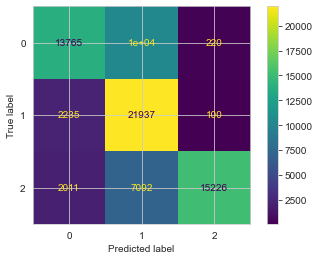

time: 157 ms (started: 2023-01-05 22:19:15 -03:00)


In [ ]:
cm_knn = confusion_matrix(y_test_st, y_pred_knn, labels=knn.classes_)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp_knn.plot();

### StratifiedKFold-KNN

In [ ]:
# Inicializa la lista para almacenar las puntuaciones F1
f1_scores = []

# Itera sobre cada submuestra
for train_index, test_index in skf.split(x_st, y_st):
    # Separa los datos en train y test utilizando los índices obtenidos por la función split
    x_train_knn, x_test_knn = x_st[train_index], x_st[test_index]
    y_train_knn, y_test_knn = y_st[train_index], y_st[test_index]

    # Entrena el modelo con los datos de entrenamiento
    knn.fit(x_train_knn, y_train_knn)

    # Realiza predicciones con el modelo entrenado en los datos de prueba
    y_pred_knn = knn.predict(x_test_knn)

    # Calcula la puntuación F1
    f1_knn = f1_score(y_true=y_test_knn, y_pred=y_pred_knn, average=None)

    # Guarda la puntuación F1 en la lista
    f1_scores.append(f1_knn)

time: 26.9 s (started: 2023-01-05 22:19:25 -03:00)


In [ ]:
f1_scores

[array([0.74330341, 0.78647544, 0.95936356]),
 array([0.7491288 , 0.78745869, 0.96270692]),
 array([0.74636182, 0.78633537, 0.96171429]),
 array([0.74252809, 0.78469817, 0.95753512]),
 array([0.74290132, 0.78655714, 0.95790649])]

time: 16 ms (started: 2023-01-05 22:21:25 -03:00)


In [ ]:
# Obtiene los índices para cada split
split_indices = list(skf.split(x_st, y_st))

# Selecciona el segundo split
train_index, test_index = split_indices[1]

time: 31 ms (started: 2023-01-05 22:21:57 -03:00)


In [ ]:
# Separa los datos en train y test utilizando los índices obtenidos por la función split
x_train_knn, x_test_knn = x_st[train_index], x_st[test_index]
y_train_knn, y_test_knn = y_st[train_index], y_st[test_index]

time: 31 ms (started: 2023-01-05 22:22:01 -03:00)


In [ ]:
# Entrena el modelo con los datos de entrenamiento
knn.fit(x_train_knn, y_train_knn)

# Realiza predicciones con el modelo entrenado en los datos de prueba
y_pred_knn = knn.predict(x_test_knn)

print(classification_report(y_test_knn,y_pred_knn))

              precision    recall  f1-score   support

           0       0.87      0.66      0.75     16188
           1       0.70      0.91      0.79     16190
           2       0.99      0.94      0.96     16204

    accuracy                           0.83     48582
   macro avg       0.85      0.83      0.83     48582
weighted avg       0.85      0.83      0.83     48582

time: 5.69 s (started: 2023-01-05 22:22:04 -03:00)


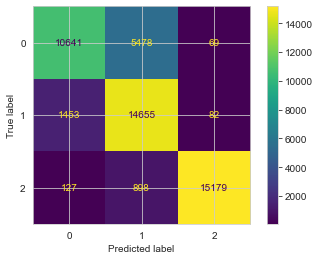

time: 296 ms (started: 2023-01-05 22:22:18 -03:00)


In [ ]:
cm_knn_skf = confusion_matrix(y_test_knn, y_pred_knn, labels=knn.classes_)
disp_knn_skf = ConfusionMatrixDisplay(confusion_matrix=cm_knn_skf, display_labels=knn.classes_)
disp_knn_skf.plot();

### RandomizedSearchCV-KNN

In [ ]:
params_knn = {
    'n_neighbors' : [5,7,10], #cantidad de vecinos
    'weights':['uniform', 'distance'], #uniform pondera = a todos los vecinos, distance inversamente proporcional a su distancia
    'algorithm': ['auto','ball_tree','kd_tree','brute'], #algoritmo para computar las distancias mas cercanas
    'p': [1,2] #1 para probar con dist manhattan, 2 para euclideana
}

grid_knn = RandomizedSearchCV(random_state=42,
                              estimator = knn,
                              param_distributions = params_knn,
                              n_iter= 5,
                              scoring = ['f1','recall'],  #metricas en base a las cuales quiero que decida que hiperparametros son mejores
                              verbose = 3, #Para que muestre cada iteracion, con su tiempo de ejecución y su scoring
                              n_jobs = -1, #Cant de corridas en paralelo, -1 es para que use todos los procesadores
                              refit='f1',
                              cv=3)

time: 0 ns (started: 2023-01-05 22:22:28 -03:00)


In [ ]:
#Se entrena al modelo con la grilla
grid_knn_fitted=grid_knn.fit(x_train_knn, y_train_knn)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\Patricio\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:953: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan]



time: 14min 38s (started: 2023-01-05 22:22:35 -03:00)


In [ ]:
grid_knn_fitted.best_score_ #para ver el mejor scoring logrado

nan

time: 0 ns (started: 2023-01-05 22:41:24 -03:00)


In [ ]:
grid_knn_fitted.best_params_ #para ver los parámetros que logran ese mejor scoring

{'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'algorithm': 'kd_tree'}

time: 0 ns (started: 2023-01-05 22:41:26 -03:00)


In [ ]:
knn_grid = KNeighborsClassifier(weights='distance',
                                p=2,
                                n_neighbors=5,
                                algorithm='kd_tree')
knn_grid.fit(x_train_knn,y_train_knn)
y_predicted_knn_grid = knn_grid.predict(x_test_knn)

time: 7min 9s (started: 2023-01-05 22:43:01 -03:00)


In [ ]:
print(classification_report(y_test_knn, y_predicted_knn_grid))

              precision    recall  f1-score   support

           0       0.88      0.62      0.73     16188
           1       0.64      0.92      0.76     16190
           2       0.99      0.84      0.91     16204

    accuracy                           0.80     48582
   macro avg       0.84      0.80      0.80     48582
weighted avg       0.84      0.80      0.80     48582

time: 32 ms (started: 2023-01-05 22:50:10 -03:00)


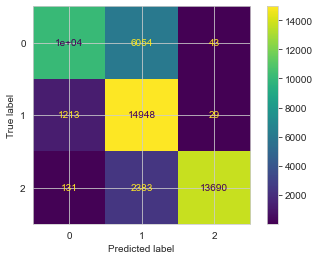

time: 94 ms (started: 2023-01-05 22:50:43 -03:00)


In [ ]:
cm_knn_grid = confusion_matrix(y_test_knn, y_predicted_knn_grid, labels=knn_grid.classes_)
disp_knn_grid = ConfusionMatrixDisplay(confusion_matrix=cm_knn_grid, display_labels=knn_grid.classes_)
disp_knn_grid.plot();

# Conclusión Final

Podemos ver que el modelo que mejores resultados arrojó fue un random forest de las siguientes caracterísitcas: 
"RandomForestClassifier(random_state=42, n_estimators=20)", utilizando la mejor partición de datos train/test según el método StratifiedKFolds, y la técnica de oversampling SMOTETomek.

El mismo arrojó estos resultados:

            precision    recall  f1-score   support
       0       0.84      0.86      0.85     16187
       1       0.86      0.83      0.84     16190
       2       0.99      1.00      0.99     16205

    accuracy                           0.90     48582
    macro avg      0.90      0.90      0.90     48582
    weighted avg   0.90      0.90      0.90     48582


Por esta razón, decidimos recomendar al banco el modelo de las características mencionadas.

Tiene sentido que de mejor el RandomForest por sobre knn; ya que RandomForest implementa mas de un algoritmo (árbol) en simultáneo, lo cual lo vuelve más preciso y resistente al overfitting.


###Análisis final de las métricas e insights

Los resultados del modelo muestran que el modelo tiene una precisión y un recall bastante altos. A continuación, se explicarán cada una de las métricas:

**Precision**: La precisión es la fracción de predicciones positivas que son correctas. En nuestro caso, la precisión para las clases 0, 1 y 2 es de 0.84, 0.86 y 0.99, respectivamente. Esto significa que el modelo es capaz de predecir correctamente el 84% de los clientes que no tomaron préstamos, el 86% de los buenos pagadores y el 99% de los malos pagadores.

**Recall**: El recall es la fracción de verdaderos positivos que son detectados por el modelo. En este caso, el recall para las clases 0, 1 y 2 es de 0.86, 0.83 y 1.00, respectivamente. Esto significa que el modelo es capaz de detectar el 86% de los clientes que no tomaron préstamos, el 83% de los buenos pagadores y el 100% de los malos pagadores.

**f1-score**: El f1-score es una métrica que combina precision y recall y se calcula como la media armónica de ambas. En nuestro caso, el f1-score para las clases 0, 1 y 2 es de 0.85, 0.84 y 0.99, respectivamente. Esto significa que el modelo tiene una precisión y un recall bastante similares para las clases 0 y 1, y una precisión y un recall muy altos para la clase 2.


Teniendo esto en cuenta, queremos destacar que el modelo tiene una performance prácticamente perfecta en la clase 2 (Malos pagadores); por lo cual si un cliente es clasificado como mal pagador, recomendamos a la empresa no otorgar el préstamo.
Mientras tanto, en las clases 0(No toma préstamo) y 1(Buen pagador), si bien el rendimiento del modelo es muy bueno, presenta un pequeño margen de error. Para solucionar esto, sugerimos en estos realizar un análisis mas pormenorizado para cada cliente clasificado en clases 0 y 1 antes de tomar una decisión al respecto.